In [0]:
# from google.colab import files
# uploaded = files.upload()

Saving pm2.5_non_normalised.csv to pm2.5_non_normalised.csv


In [0]:
from pandas import DataFrame
import pandas

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

n_step = 3

dataset = read_csv('pm2.5_non_normalised.csv', header=0, index_col=0)
dataset = series_to_supervised(dataset, n_step, 1)
values = dataset.values
print(values)


n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print(train.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X)
print(train_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 3, 1))
test_X = test_X.reshape((test_X.shape[0], 3, 1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[129.77867   148.89336   159.95975   182.09255  ]
 [148.89336   159.95975   182.09255   138.83299  ]
 [159.95975   182.09255   138.83299   109.65794  ]
 ...
 [  9.0543255  10.060362    8.048289   10.060362 ]
 [ 10.060362    8.048289   10.060362   10.060362 ]
 [  8.048289   10.060362   10.060362    8.048289 ]]
(35040, 4)
[[129.77867  148.89336  159.95975 ]
 [148.89336  159.95975  182.09255 ]
 [159.95975  182.09255  138.83299 ]
 ...
 [ 23.138832  20.120723  23.138832]
 [ 20.120723  23.138832  24.14487 ]
 [ 23.138832  24.14487   53.319916]]
[182.09255  138.83299  109.65794  ...  24.14487   53.319916  65.39235 ]
(35040, 3, 1) (35040,) (8756, 3, 1) (8756,)


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_step,
  1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# demonstrate prediction










Train on 35040 samples, validate on 8756 samples
Epoch 1/100
 - 1s - loss: 1286.6438 - val_loss: 678.3644
Epoch 2/100
 - 1s - loss: 866.8657 - val_loss: 650.8300
Epoch 3/100
 - 1s - loss: 840.0586 - val_loss: 655.8439
Epoch 4/100
 - 1s - loss: 837.2743 - val_loss: 653.4600
Epoch 5/100
 - 1s - loss: 839.4864 - val_loss: 630.8058
Epoch 6/100
 - 1s - loss: 826.5990 - val_loss: 626.1582
Epoch 7/100
 - 1s - loss: 820.9902 - val_loss: 620.7617
Epoch 8/100
 - 1s - loss: 815.8515 - val_loss: 618.3914
Epoch 9/100
 - 1s - loss: 813.7787 - val_loss: 617.4609
Epoch 10/100
 - 1s - loss: 812.7583 - val_loss: 614.3974
Epoch 11/100
 - 1s - loss: 811.7874 - val_loss: 614.4482
Epoch 12/100
 - 1s - loss: 809.7363 - val_loss: 613.2955
Epoch 13/100
 - 1s - loss: 807.4705 - val_loss: 613.3446
Epoch 14/100
 - 1s - loss: 804.9562 - val_loss: 612.7622
Epoch 15/100
 - 1s - loss: 802.3165 - val_loss: 612.5230
Epoch 16/100
 - 1s - loss: 801.0479 - val_loss: 612.3755
Epoch 17/100
 - 1s - loss: 800.6498 - val

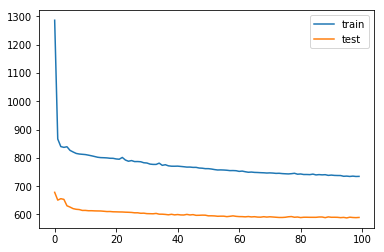

In [0]:
# plot history
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
from math import sqrt
from numpy import concatenate
#from numpy import scaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# # make a prediction
# print(test_X.shape)
# # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
# scaler = StandardScaler()
# scaler.fit(test_X)
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print(rmse)

# print(test_y)
# print(yhat)

In [0]:
test_X = test_X.reshape((test_X.shape[0], n_step, 1))
yhat = model.predict(test_X)
print(test_y)
print(yhat)

rms = (mean_squared_error(yhat, test_y))
print(rms)

[70.42253  79.476856 92.55533  ... 10.060362 10.060362  8.048289]
[[74.389984]
 [75.93067 ]
 [84.56727 ]
 ...
 [11.115402]
 [11.382996]
 [11.902435]]
589.5729277124229


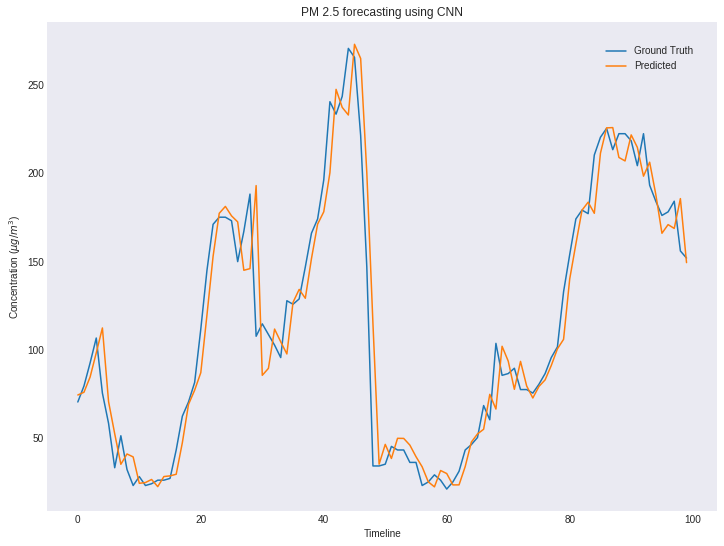

In [0]:
import matplotlib.pyplot as plt

plt.plot(test_y[:100], label="Ground Truth")
plt.plot( yhat[:100], label="Predicted")


plt.style.use('seaborn-dark')
plt.ylabel("Concentration ($\mu g / m^3$)")
plt.xlabel("Timeline")
plt.legend(loc="upper right", borderaxespad=2)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

plt.title("PM 2.5 forecasting using CNN")

plt.show()